<a href="https://colab.research.google.com/github/RapoluUma956/AI_PCB_Defect_Detection_Classification_System/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import os
import random
import re
import shutil
sns.set_style('darkgrid')
sns.set_palette('pastel')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Defining the input
input_dir='/content/drive/MyDrive/PCB_DATASET/'
os.listdir(input_dir)

['rotate.py',
 'images',
 'Defect_Patches',
 'PCB_USED',
 'rotation',
 'Annotations',
 'images_combined']

In [ ]:
template_dir=os.path.join(input_dir,'PCB_USED')
template_dir

'/content/drive/MyDrive/PCB_DATASET/PCB_USED'

In [ ]:
#Defining the image directory
img_dir=os.path.join(input_dir,'images')

#Listing the types of defects
os.listdir(img_dir)
types_defect=os.listdir(os.path.join(input_dir,'images'))
types_defect

['Missing_hole',
 'Mouse_bite',
 'Open_circuit',
 'Short',
 'Spur',
 'Spurious_copper']

In [ ]:
#Creating an image path list for ready refernce
img_path_list=[]
#Creating img_path list
for sub_cat in types_defect:
    sub_sub_cats = os.listdir(os.path.join(img_dir,sub_cat))
    for sub_sub_cat in sub_sub_cats:
        for file in os.listdir(os.path.join(img_dir,sub_cat,sub_sub_cat)):
            img_path_list.append(os.path.join(img_dir,sub_cat,sub_sub_cat,file))

In [ ]:
rotated_dir=os.path.join(input_dir,'rotation')
os.listdir(rotated_dir)

['Missing_hole_angles.txt',
 'Spur_angles.txt',
 'Mouse_bite_angles.txt',
 'Short_angles.txt',
 'Spurious_copper_angles.txt',
 'Open_circuit_angles.txt',
 'Short_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Spur_rotation']

In [ ]:
rotated_angle_list=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')]
rotated_angle_list

['Missing_hole_angles.txt',
 'Spur_angles.txt',
 'Mouse_bite_angles.txt',
 'Short_angles.txt',
 'Spurious_copper_angles.txt',
 'Open_circuit_angles.txt']

In [ ]:
types_defect_rotated=[j for j in os.listdir(rotated_dir) if j.endswith('.txt')==False]
types_defect_rotated

['Short_rotation',
 'Mouse_bite_rotation',
 'Missing_hole_rotation',
 'Spurious_copper_rotation',
 'Open_circuit_rotation',
 'Spur_rotation']

In [ ]:
annote_dir=os.path.join(input_dir,'Annotations')
annote_dir

'/content/drive/MyDrive/PCB_DATASET/Annotations'

In [ ]:
type_annot=os.listdir(annote_dir)
type_annot

['Missing_hole',
 'Short',
 'Spurious_copper',
 'Spur',
 'Open_circuit',
 'Mouse_bite']

In [ ]:
#Checking the type of files
file_list=os.listdir(os.path.join(annote_dir,'Mouse_bite'))
file_list[0:5]

['08_mouse_bite_04.xml',
 '06_mouse_bite_04.xml',
 '06_mouse_bite_08.xml',
 '10_mouse_bite_05.xml',
 '12_mouse_bite_03.xml']

In [ ]:
#importing xml ET to parse xml file
import xml.etree.ElementTree as ET

In [ ]:
#Parsing XML to return Bounding box dimensions
def parse_xml(xml_file):

    data=[]

    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
#Retrieving data for all files
data=[]
all_data=[]

for x in type_annot:
    for file in os.listdir(os.path.join(annote_dir,x)):
        xml_file_path=os.path.join(os.path.join(annote_dir,x),file)
        data=parse_xml(xml_file_path)
        all_data.extend(data)

In [ ]:
#Creating a dataframe to store the annotations
df_annot=pd.DataFrame(all_data)
df_annot

filename  width  height         class  xmin  ymin  xmax  \
0     09_missing_hole_03.jpg   2775    2159  missing_hole  1543   358  1612   
1     09_missing_hole_03.jpg   2775    2159  missing_hole  1897   646  1961   
2     09_missing_hole_03.jpg   2775    2159  missing_hole   563  1058   630   
3     09_missing_hole_03.jpg   2775    2159  missing_hole   199   638   276   
4     09_missing_hole_03.jpg   2775    2159  missing_hole  1833    97  1900   
...                      ...    ...     ...           ...   ...   ...   ...   
2948    01_mouse_bite_15.jpg   3034    1586    mouse_bite   601  1053   635   
2949    01_mouse_bite_15.jpg   3034    1586    mouse_bite  2651   558  2684   
2950    04_mouse_bite_05.jpg   3056    2464    mouse_bite   701   642   762   
2951    04_mouse_bite_05.jpg   3056    2464    mouse_bite  1106   621  1170   
2952    04_mouse_bite_05.jpg   3056    2464    mouse_bite  1595   473  1648   

      ymax  
0      422  
1      720  
2     1118  
3      704  
4      158  
...    ...  
2948  1084  
2949   591  
2950   724  
2951   688  
2952   551  

[2953 rows x 8 columns]

In [ ]:
# Don't run this cell multiple times as it will create multiple copies of the images

import os
import shutil

# Path to the main images folder (stored in img_dir)
img_dir = "/content/drive/MyDrive/PCB_DATASET/images/"  # Path to your images folder

# Define the source directories for each category inside img_dir
source_dirs = [
    os.path.join(img_dir, "Missing_hole"),
    os.path.join(img_dir, "Mouse_bite"),
    os.path.join(img_dir, "Open_circuit"),
    os.path.join(img_dir, "Short"),
    os.path.join(img_dir, "Spur"),
    os.path.join(img_dir, "Spurious_copper")
]

# Define the destination directory for the combined images (Writable location)
destination_dir = "/content/drive/MyDrive/PCB_DATASET/images_combined/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop through each source directory and copy all files to the destination
for source_dir in source_dirs:
    if os.path.exists(source_dir):
        # Get all files in the current directory
        files = os.listdir(source_dir)

        # Copy each file to the destination directory
        for file in files:
            file_path = os.path.join(source_dir, file)
            if os.path.isfile(file_path):
                shutil.copy(file_path, destination_dir)
    else:
        print(f"Directory {source_dir} does not exist.")

# Now check how many files are in the destination folder
files_in_combined = os.listdir(destination_dir)
print(f"Number of files copied: {len(files_in_combined)}")

Text(0.5, 0, 'No of defects in one PCB')

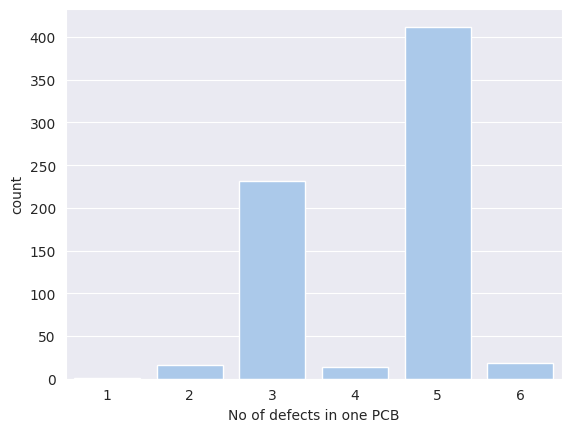

In [ ]:
#Visualizing the no of defects in each pcb
df_multiple_defects=pd.DataFrame(df_annot['filename'].value_counts())
sns.countplot(df_multiple_defects,x='count')
plt.xlabel('No of defects in one PCB')

In [ ]:
#Defining a function to view image along with bounding box

def draw_bounding_boxes(image_path, bounding_boxes,annotation):
    """
    Draws multiple bounding boxes on an image using Matplotlib.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes, each represented as a tuple or list containing
                       (min_x, min_y, max_x, max_y).
    """

    # Load the image
    img = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15,10))

    # Display the image
    ax.imshow(img)

    # Draw each bounding box
    for bbox in bounding_boxes:
        min_x, min_y, max_x, max_y = bbox
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Calculate the centroid of the bounding box
        centroid_x = (min_x + max_x) / 2
        centroid_y = (min_y + max_y) / 2

        # Add the annotation to the centroid
        ax.annotate( annotation,(centroid_x,centroid_y),(max_x+20,max_y+20),
            fontsize=10,color='white',
            horizontalalignment='right', verticalalignment='top')

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])



    # Show the plot
    plt.show()

In [ ]:
#Getting filename from filepath
filepath=img_path_list[0]
filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)


In [ ]:
filepath

'/content/drive/MyDrive/PCB_DATASET/images/Missing_hole/01_missing_hole/01_missing_hole_08.jpg'

In [ ]:
filename

'01_missing_hole_08.jpg'

In [ ]:
#Defining function to select the a file and return image along with bounding box
def visualize_annotations(list_image_path,df):
    for i in list_image_path:
        filepath=i
        filename=re.sub(r'.+/([\w_]+\.jpg)',r'\1',filepath)
        df_selected=df[df['filename']==filename]
        width=df_selected['width'].values
        height=df_selected['height'].values
        class_name=df_selected['class'].values
        xmin=df_selected['xmin'].values
        ymin=df_selected['ymin'].values
        xmax=df_selected['xmax'].values
        ymax=df_selected['ymax'].values

        bbox=zip(xmin,ymin,xmax,ymax)
        draw_bounding_boxes(filepath, bbox,class_name[0])

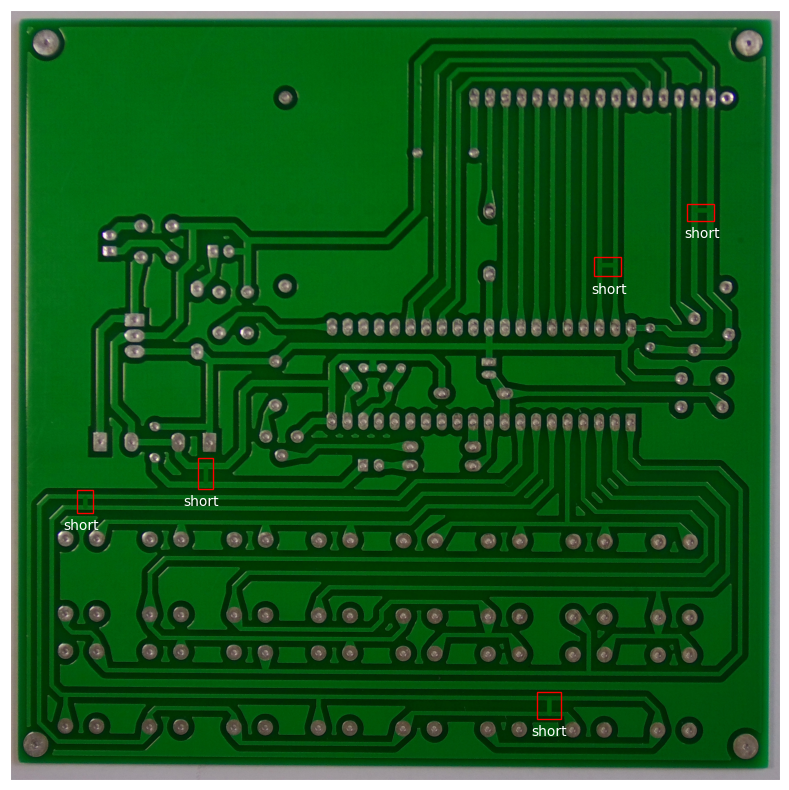

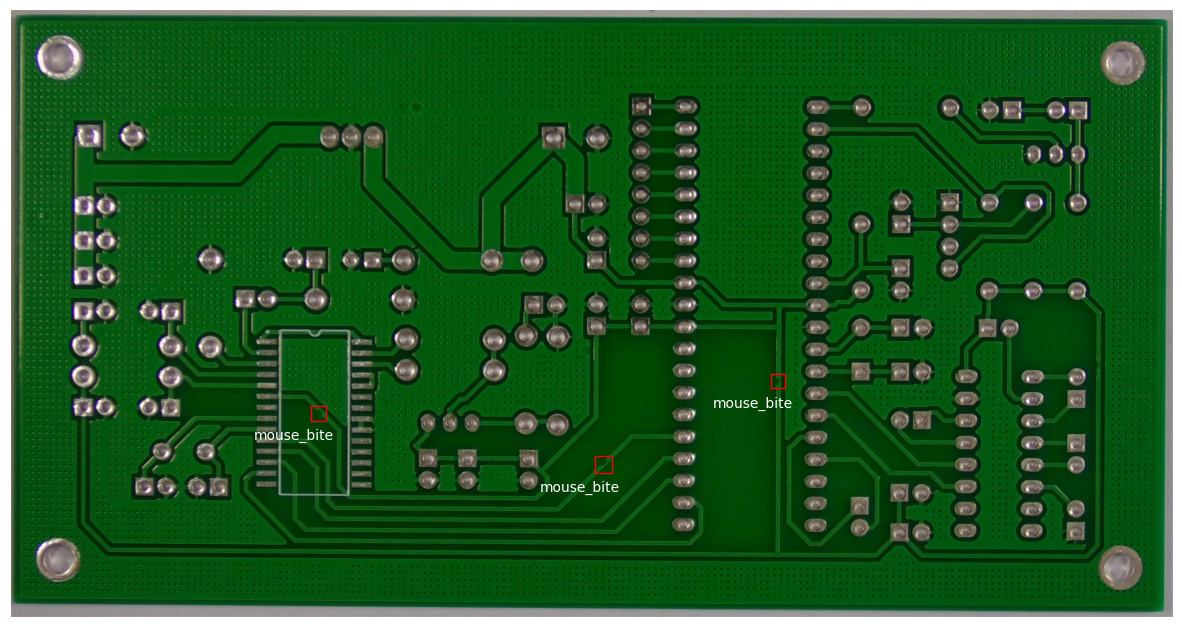

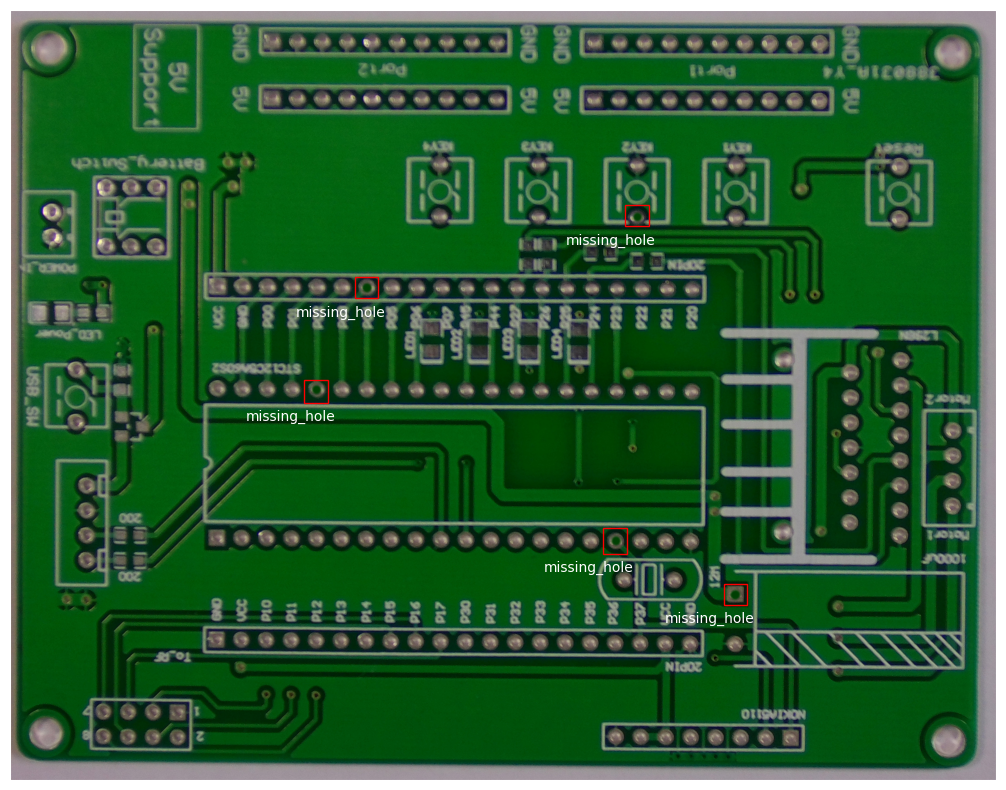

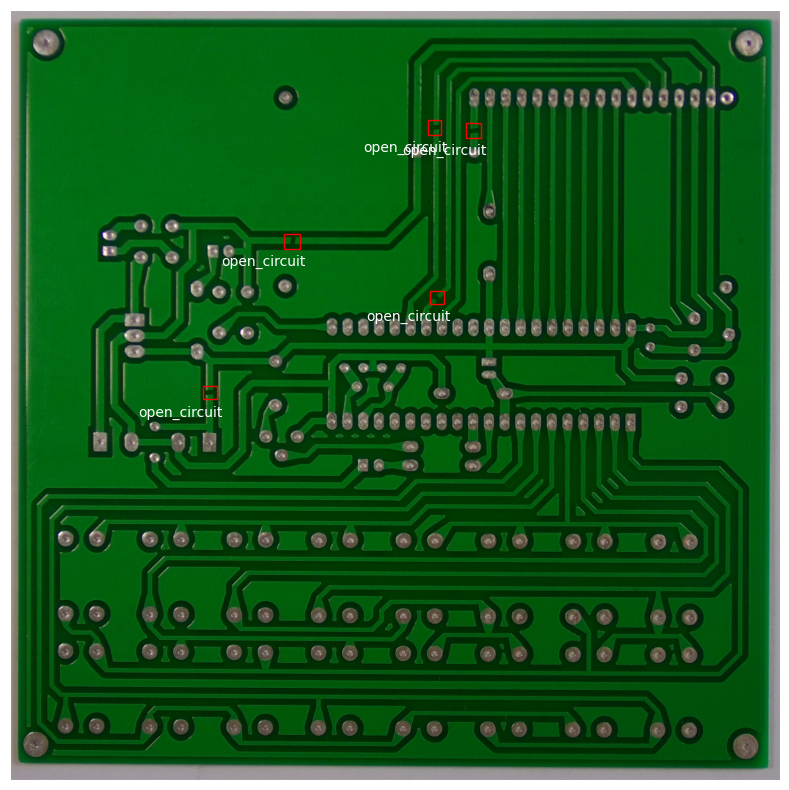

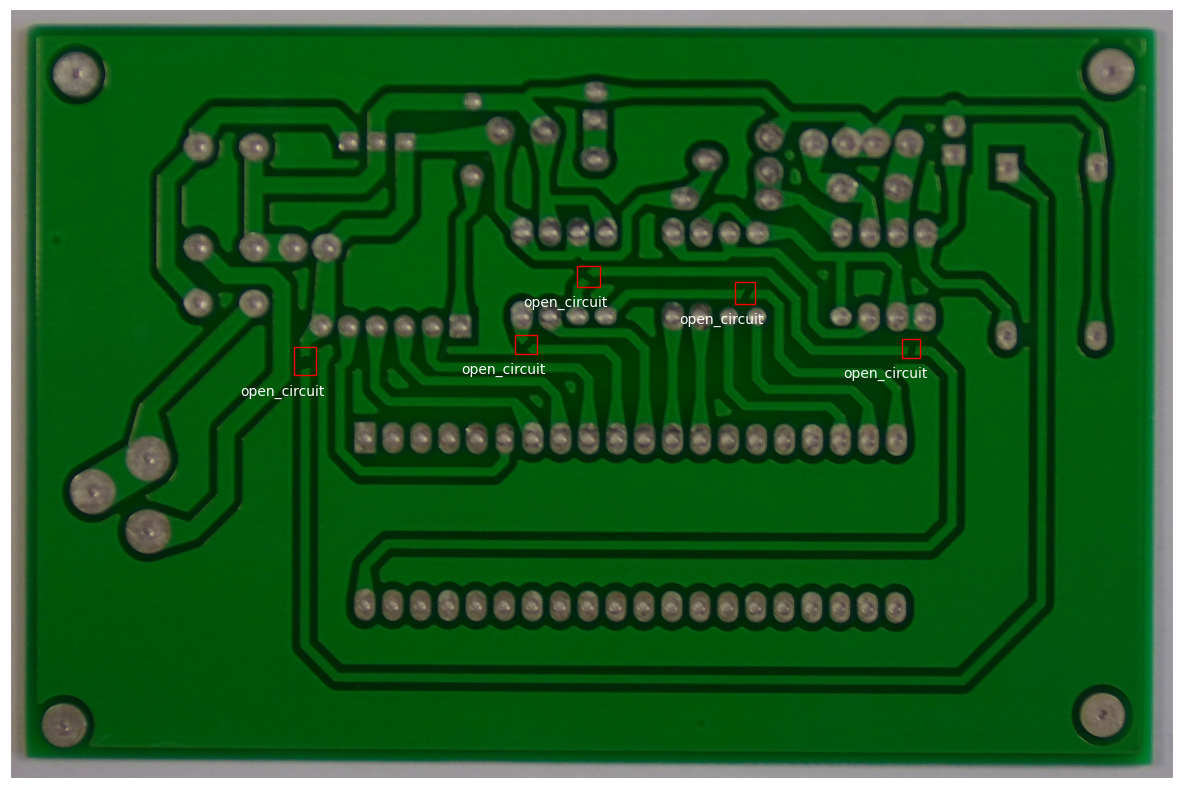

In [ ]:
random.shuffle(img_path_list)

visualize_annotations(img_path_list[0:5],df_annot)

In [ ]:
destination_dir = "/content/drive/MyDrive/PCB_DATASET/images_combined/"

In [ ]:
#Training and Testing Data

In [ ]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
import yaml

# ==========================================================
# CONFIGURATION
# ==========================================================
YOLO_ROOT = "pcb_yolo"
IMG_DIR = destination_dir       # your original image directory
DF = df_annot.copy()     # annotation dataframe

# Create YOLO directory structure
for split in ["train", "val", "test"]:
    os.makedirs(f"{YOLO_ROOT}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_ROOT}/labels/{split}", exist_ok=True)

# ==========================================================
# CLASS MAPPING
# ==========================================================
class_names = sorted(DF["class"].unique())
class_to_id = {cls: idx for idx, cls in enumerate(class_names)}

print("Class mapping:")
for k, v in class_to_id.items():
    print(f"{k} -> {v}")

# ==========================================================
# FILE-WISE TRAIN / VAL / TEST SPLIT (NO LEAKAGE)
# ==========================================================
unique_files = DF["filename"].unique()

train_files, temp_files = train_test_split(
    unique_files, test_size=0.3, random_state=42
)

val_files, test_files = train_test_split(
    temp_files, test_size=0.5, random_state=42
)

splits = {
    "train": train_files,
    "val": val_files,
    "test": test_files
}

# ==========================================================
# FUNCTION TO CONVERT ONE IMAGE TO YOLO LABEL
# ==========================================================
def convert_to_yolo(df_split, split_name):
    grouped = df_split.groupby("filename")

    for filename, rows in grouped:
        img_path = os.path.join(IMG_DIR, filename)
        if not os.path.exists(img_path):
            print(f"Image missing: {filename}")
            continue

        # Open image to get dimensions
        with Image.open(img_path) as img:
            img_w, img_h = img.size

        # Copy image
        shutil.copy(
            img_path,
            f"{YOLO_ROOT}/images/{split_name}/{filename}"
        )

        label_path = f"{YOLO_ROOT}/labels/{split_name}/{os.path.splitext(filename)[0]}.txt"

        with open(label_path, "w") as f:
            for _, row in rows.iterrows():
                class_id = class_to_id[row["class"]]

                xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]

                # YOLO format (normalized)
                x_center = ((xmin + xmax) / 2) / img_w
                y_center = ((ymin + ymax) / 2) / img_h
                width = (xmax - xmin) / img_w
                height = (ymax - ymin) / img_h

                f.write(
                    f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                )

# ==========================================================
# GENERATE YOLO DATA
# ==========================================================
for split_name, files in splits.items():
    df_split = DF[DF["filename"].isin(files)]
    convert_to_yolo(df_split, split_name)

print("YOLO labels and images created successfully.")

# ==========================================================
# CREATE data.yaml
# ==========================================================
data_yaml = {
    "path": YOLO_ROOT,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "nc": len(class_names),
    "names": class_names
}

with open(f"{YOLO_ROOT}/data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

print("data.yaml created successfully.")

Class mapping:
missing_hole -> 0
mouse_bite -> 1
open_circuit -> 2
short -> 3
spur -> 4
spurious_copper -> 5
YOLO labels and images created successfully.
data.yaml created successfully.


In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00


In [ ]:
# Training

In [ ]:
# ===================================================================
# 3. YOLOv8 TRAINING
# ===================================================================

from ultralytics import YOLO
import os # Import os module to handle paths

# Load a pretrained YOLOv8 model
# yolo8n = nano (small & fast) → BEST for your dataset size
model = YOLO("yolov8n.pt")

# Train the model
model.train(
    data=os.path.join(YOLO_ROOT, "data.yaml"),          # path to your data.yaml
    epochs=100,                # YOLO needs more epochs than CNNs
    imgsz=640,                 # standard YOLO input size
    batch=16,
    device="cpu",
    patience=20,               # early stopping
    optimizer="AdamW",         # works better for small datasets
    lr0=0.001,
    weight_decay=0.0005,
    hsv_h=0.015,               # light augmentations (PCB safe)
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=5,
    translate=0.05,
    scale=0.2,
    flipud=0.0,                # NO vertical flip for PCB
    fliplr=0.5,
    mosaic=0.3                 # low mosaic (important!)
)


Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pcb_yolo/data.yaml, degrees=5, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.3, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79946b7baff0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [ ]:
model.val(
    data=os.path.join(YOLO_ROOT, "data.yaml"),
    split="test",
    device="cpu"
)

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 114.3±23.4 MB/s, size: 1400.2 KB)
val: Scanning /content/pcb_yolo/labels/test... 104 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 104/104 223.8it/s 0.5s
val: New cache created: /content/pcb_yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.2s/it 22.5s
                   all        104        431      0.932      0.821       0.87      0.452
          missing_hole         21         93      0.989      0.967      0.981      0.595
            mouse_bite         16         65      0.914      0.656      0.794      0.371
          open_circuit         18         71      0.876      0.789      0.855      0.405
                 short         16         68      0.921      0.926      0.965      0.458
                  spur         15         58      0.928      0.707      0.719      0.3

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799463e4c3e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

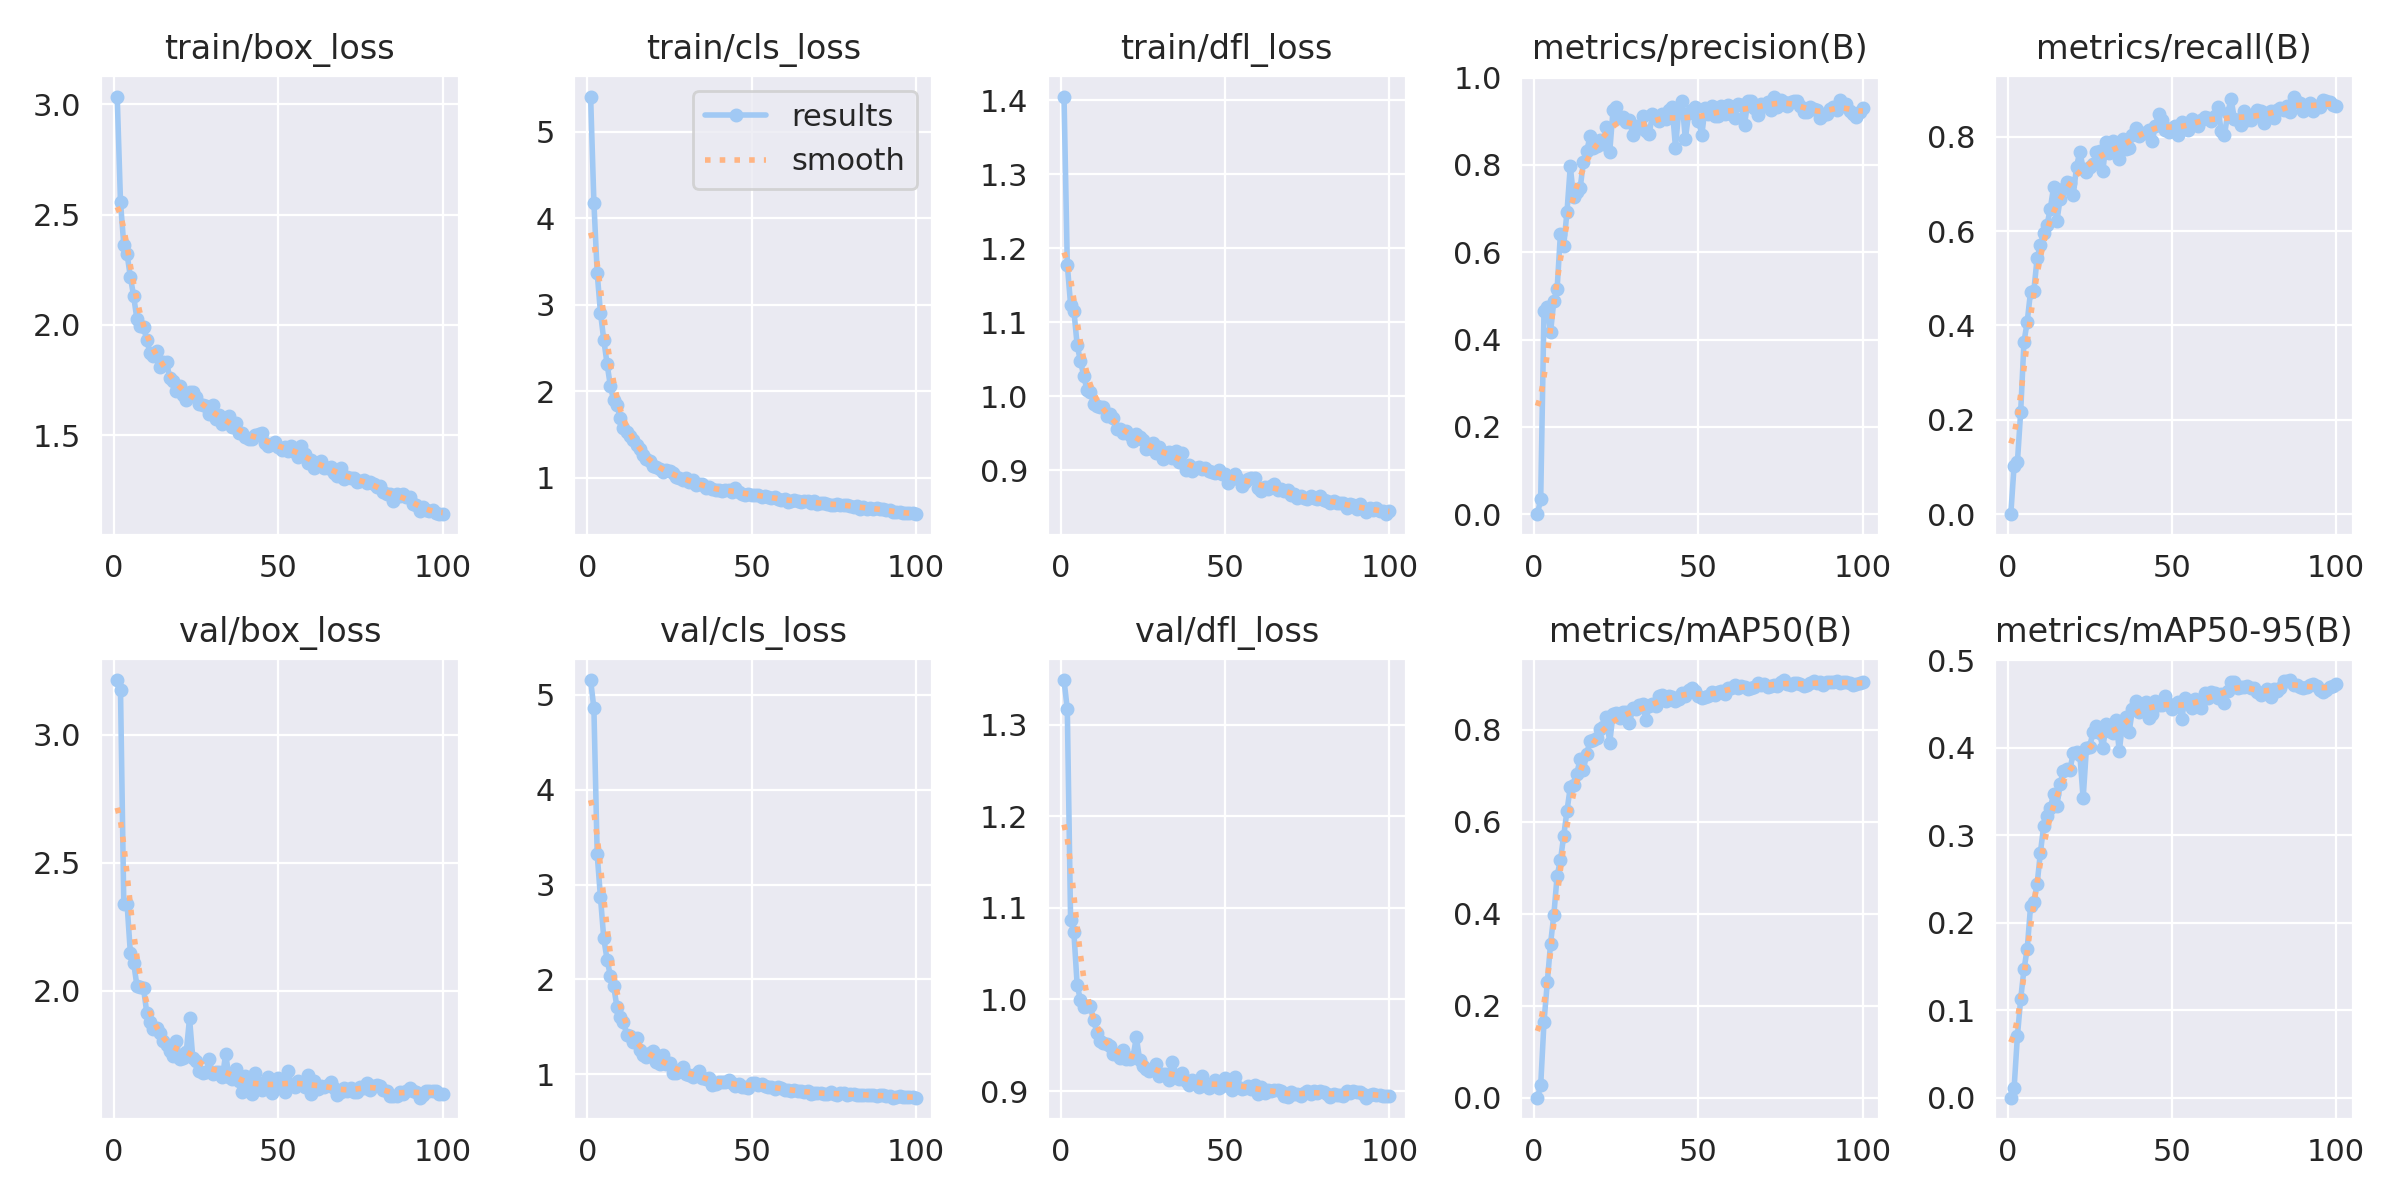

In [ ]:
from IPython.display import Image, display

display(Image("/content/runs/detect/train2/results.png"))

In [ ]:
import shutil
import os

# Source YOLO best model
YOLO_BEST_MODEL = "/content/runs/detect/train2/weights/best.pt"

# Destination path (Google Drive)
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/best_yolov8_pcb_defects.pt"

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# Copy the model
shutil.copy(YOLO_BEST_MODEL, SAVE_PATH)

print(f"YOLO model saved to {SAVE_PATH}")

YOLO model saved to /content/drive/MyDrive/Colab Notebooks/best_yolov8_pcb_defects.pt


In [ ]:
#Inference

--- YOLOv8 PCB DEFECT INFERENCE PIPELINE ---
Classes: {0: 'missing_hole', 1: 'mouse_bite', 2: 'open_circuit', 3: 'short', 4: 'spur', 5: 'spurious_copper'}

Running YOLO on: 05_spurious_copper_01.jpg
Detections found: 5


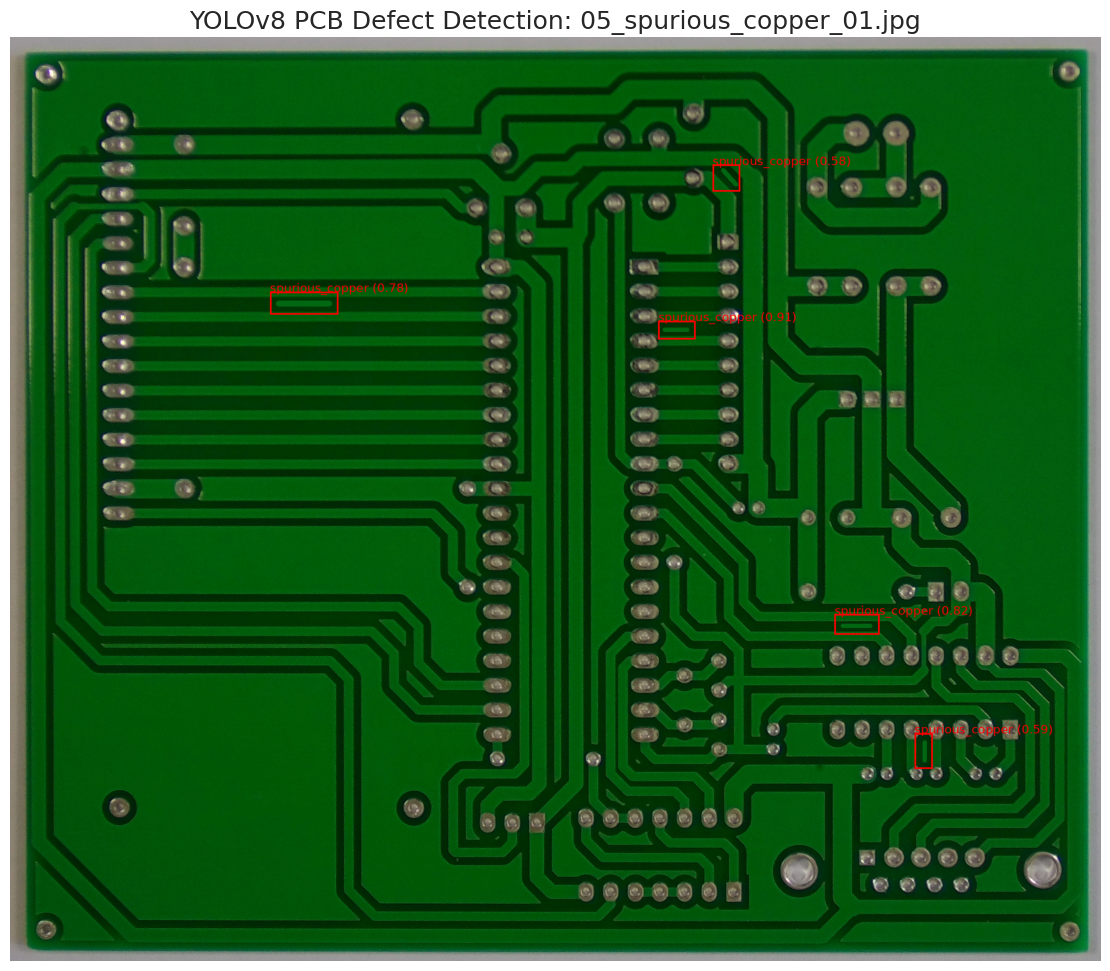

In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from ultralytics import YOLO

print("--- YOLOv8 PCB DEFECT INFERENCE PIPELINE ---")

# =====================================================
# 1. LOAD YOLO MODEL
# =====================================================
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/best_yolov8_pcb_defects.pt"

model = YOLO(MODEL_PATH)

# Automatically loaded from training
class_names = model.names
print("Classes:", class_names)

# =====================================================
# 2. YOLO INFERENCE FUNCTION
# =====================================================
def run_yolo_inference(image_pil, conf=0.3, iou=0.5):
    results = model.predict(
        source=image_pil,
        conf=conf,
        iou=iou,
        device="cpu",   # change to 0 if GPU exists
        verbose=False
    )

    detections = []

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_id = int(box.cls[0])
            confidence = float(box.conf[0])

            detections.append({
                "box": [x1, y1, x2, y2],
                "label": class_names[cls_id],
                "confidence": confidence
            })

    return detections


# =====================================================
# 3. DRAW DETECTIONS
# =====================================================
def draw_detections(image, detections):
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 28)
    except:
        font = ImageFont.load_default()

    for det in detections:
        x1, y1, x2, y2 = det["box"]
        label = f"{det['label']} ({det['confidence']:.2f})"

        draw.rectangle([x1, y1, x2, y2], outline="red", width=4)
        draw.text((x1, y1 - 25), label, fill="red", font=font)

    return image


# =====================================================
# 4. RUN ON TEST IMAGE
# =====================================================
test_image_path = "/content/drive/MyDrive/PCB_DATASET/images/Spurious_copper/05_spurious_copper/05_spurious_copper_01.jpg"
image_name = os.path.basename(test_image_path)

print(f"\nRunning YOLO on: {image_name}")

image = Image.open(test_image_path).convert("RGB")

detections = run_yolo_inference(
    image_pil=image,
    conf=0.35,   # tune this
    iou=0.5
)

print(f"Detections found: {len(detections)}")

result_image = draw_detections(image, detections)

plt.figure(figsize=(18, 12))
plt.imshow(result_image)
plt.title(f"YOLOv8 PCB Defect Detection: {image_name}", fontsize=18)
plt.axis("off")
plt.show()
